In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from typing_extensions import Literal
from typing import Optional, List
from sklearn import datasets
from Layer import Layer
from MLP import MLP

# Utils

In [12]:
import sys
sys.path.append('../')

In [13]:
from random_mix import random_mix
from random_sampling import random_sampling

In [2]:
def get_names(pitch: bool = 1, dynamics: bool = 1, rhythm: bool = 1, timbre: bool = 1):
    '''
    Input: booleans indicating the types of features to be used (pitch, dynamics, rhythm and timbre)
    Output: Returns a list of the names of the features for the activated types of features
    '''
    pitch = []
    for i in range(12):
        pitch.extend([str(i+1)+"_pitch_min", str(i+1)+"_pitch_max", str(i+1)+"_pitch_mean", str(i+1)+"_pitch_std"])
    
    dynamics = []
    dynamics.extend(["spectral_centroid_min", "spectral_centroid_max", "spectral_centroid_mean", "spectral_centroid_std"])
    dynamics.extend(["zero_crossing_rate_min", "zero_crossing_rate_max", "zero_crossing_rate_mean", "zero_crossing_rate_std"])
    dynamics.extend(["spectral_rolloff_min", "spectral_rolloff_max", "spectral_rolloff_mean", "spectral_rolloff_std"])

    rhythm = []
    rhythm.extend(["tempogram_min", "tempogram_max", "tempogram_mean", "tempogram_std"])

    timbre = []
    for i in range(20):
        timbre.extend([str(i+1)+"_mfcc_min", str(i+1)+"_mfcc_max", str(i+1)+"_mfcc_mean", str(i+1)+"_mfcc_std"])

    features_names = []
    if(pitch):
        features_names.extend(pitch)
    if(dynamics):
        features_names.extend(dynamics)
    if(rhythm):
        features_names.extend(rhythm)
    if(timbre):
        features_names.extend(timbre)

    return features_names

In [17]:
def get_train_test(size: float , X: np.ndarray, y: np.ndarray):
  '''
  Input:
  - suggested: is the suggested number of samples according to PAG
  - X: the data
  - y: the labels

  Output:
  - X_train: the training data with suggested samples
  - y_train: the training labels
  - X_test: the test set with all the data not chosen for training
  - y_test: the test labels
  '''
  X_mixed = random_mix(np.append(X,y.reshape(y.shape[0],1), axis = 1))
  X_train, X_test = random_sampling(X_mixed, size = size)
  X_train, y_train =  X_train[:,:-1], X_train[:,-1]
  X_test, y_test =  X_test[:,:-1], X_test[:,-1]
  assert X_train.shape[0] == y_train.shape[0]
  assert X_test.shape[0] == y_test.shape[0]
  return X_train, y_train, X_test, y_test

# Load Data

In [8]:
# Read iris to test the MLP
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
X_iris.shape

(150, 4)

In [5]:
# Read musical features
infile = open('dataset_features.pckl','rb')
features = pickle.load(infile)
infile.close()
features.shape

(201, 145)

In [6]:
# Create dataframe with features
names = get_names()
names.append("Label")
df = pd.DataFrame(features, columns = names)
list_cols = []
for coll in df.columns:
  col = str(coll)
  if(col.find("pitch") > 0 and (col.find("min") > 0 or col.find("max") > 0)): 
    continue
  if(col in ["tempogram_min", "tempogram_max"]):
    continue
  list_cols.append(col)
df_songs = df[list_cols]
df_songs.head()

,1_pitch_mean,1_pitch_std,2_pitch_mean,2_pitch_std,3_pitch_mean,3_pitch_std,4_pitch_mean,4_pitch_std,5_pitch_mean,5_pitch_std,...,18_mfcc_std,19_mfcc_min,19_mfcc_max,19_mfcc_mean,19_mfcc_std,20_mfcc_min,20_mfcc_max,20_mfcc_mean,20_mfcc_std,Label
0,0.367158,0.250658,0.446059,0.303279,0.345249,0.267387,0.378227,0.330485,0.358498,0.265262,...,6.322423,-35.063286,22.445841,-6.158485,7.843939,-15.309130,32.983795,5.411145,6.995747,0.0
1,0.548021,0.321238,0.505586,0.274560,0.521004,0.300331,0.554739,0.276167,0.581093,0.289333,...,7.282372,-24.618061,21.180487,-0.404446,5.324600,-18.628052,39.097198,3.593739,5.749859,0.0
2,0.228689,0.281790,0.141832,0.164917,0.200010,0.270996,0.226451,0.255719,0.352861,0.332630,...,7.605660,-29.139126,22.793182,-1.253622,7.343888,-26.660023,21.146843,-0.899938,6.930117,0.0
3,0.341178,0.246983,0.478602,0.343246,0.281382,0.211076,0.306389,0.270918,0.313350,0.240436,...,5.671211,-28.038145,19.897411,-5.406955,5.860555,-18.276693,26.443262,1.132697,6.015408,0.0
4,0.227324,0.213584,0.520437,0.396417,0.204974,0.203153,0.249976,0.289113,0.297624,0.357263,...,7.713253,-32.549755,21.090767,-4.515356,8.532988,-27.717663,29.424013,-4.685843,8.793524,0.0


In [7]:
# Extract timbre features and labels
list_cols = []
for coll in df.columns:
  col = str(coll)
  if(col.find("mfcc") > 0 ):
    list_cols.append(col)
X_songs = df[list_cols].to_numpy()
y_songs = df['Label'].values.reshape(-1,1)

### Split data into train, test and validation

In [43]:
X_train, y_train, X_aux, y_aux =  get_train_test(size = 0.6 , X = X_songs, y = y_songs)
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0.0: 60, 1.0: 60}

In [61]:
X_test, y_test, X_val, y_val =  get_train_test(size = 0.5 , X = X_aux, y = y_aux)
# Count different values in the labels
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 20, 1.0: 20}

In [62]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0.0: 21, 1.0: 20}

# Model

Epoch:  0 Error:  0.49984683996247775


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


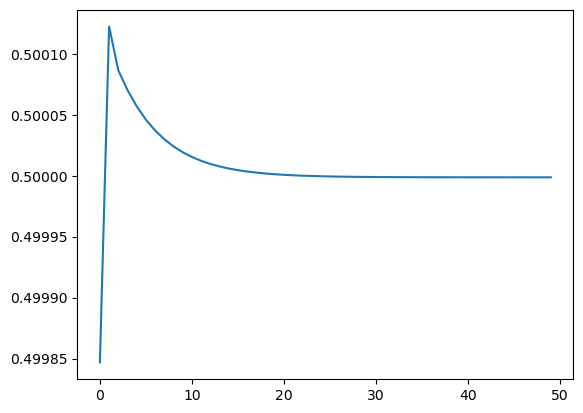

In [72]:
model = MLP(layers = [Layer(80, 1, activation = 'Sigmoid'),Layer(1, 1, activation = 'Sigmoid'),Layer(1, 1, activation = 'Sigmoid')], learning_rate = 0.1)
model.train(X_train.T, y_train.T, epochs = 50)
plt.plot(model.errors)

In [77]:
model.predict(X_test.T)
# compute error on test set
y_pred = model.predict(X_test.T)
print("Train error: ", np.mean(y_test.T - y_pred))

Train error:  0.0008183576523434876


c:\Users\isaur\miniconda3\envs\musical_taste\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


In [78]:
y_pred

array([[0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164,
        0.49918164, 0.49918164, 0.49918164, 0.49918164, 0.49918164]])

# Integrate with Wandb to record the tests

In [10]:
import wandb
import os
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: isitarex. Use `wandb login --relogin` to force relogin


True

## Tests 1 hidden layer

In [ ]:
epochs = 50
for i in range(1,6):
  for lr in [1, 0.1, 0.01]:
    run_name = "Hidden_neurons=" + str(i) + "_lr=" + str(lr)
    run = wandb.init(project ="Musical Taste Runs (1 hidden layer)",name = run_name, reinit=True)
    model = MLP(layers = [Layer(80, i, activation = 'Sigmoid'),Layer(i, 1, activation = 'Sigmoid'),Layer(1, 1, activation = 'Sigmoid')],learning_rate = lr)
    model.train(X_songs.T, y_songs.T, epochs = epochs)
    model.all_gradients = np.array(model.all_gradients)
    wandb.define_metric("Loss", summary="min")
    for iter_num in range(epochs):
      wandb.log({"Input layer gradients": model.all_gradients[iter_num,0], "Hidden layer gradients": model.all_gradients[iter_num,1], "Output layer gradients": model.all_gradients[iter_num,2]}, step = iter_num)
      wandb.log({"Loss": model.errors[iter_num]}, step = iter_num)
    print("Error: ", model.errors[-1])
    run.finish()

## Tests 2 hidden layers

In [ ]:
epochs = 50
for i in range(1,6):
  for j in range(1,6):
    for lr in [1, 0.1, 0.01]:
      run_name = "Neurons l1=" + str(i) + "_neurons l2=" + str(j) +"_lr=" + str(lr)
      run = wandb.init(project ="Musical Taste Runs (2 hidden layers)",name = run_name, reinit=True)
      model = MLP(layers = [Layer(80, i, activation = 'Sigmoid'),Layer(i, j, activation = 'Sigmoid'),Layer(j, 1, activation = 'Sigmoid'), Layer(1, 1, activation = 'Sigmoid')],learning_rate = lr)
      model.train(X_songs.T, y_songs.T, epochs = epochs)
      model.all_gradients = np.array(model.all_gradients)
      wandb.define_metric("Loss", summary="min")
      for iter_num in range(epochs):
        wandb.log({"Input layer gradients": model.all_gradients[iter_num,0], 
        "Hidden layer 1 gradients": model.all_gradients[iter_num,1], 
        "Hidden layer 2 gradients": model.all_gradients[iter_num,2], 
        "Output layer gradients": model.all_gradients[iter_num,3]}, step = iter_num)
        wandb.log({"Loss": model.errors[iter_num]}, step = iter_num)
      print("Error: ", model.errors[-1])
      run.finish()

## Tests 3 hidden layers

In [ ]:
epochs = 50
for i in range(1,6):
  for j in range(1,6):
    for k in range(1,6):
      for lr in [1, 0.1,0.01]:
        run_name = "Neurons l1=" + str(i) + " Neurons l2=" + str(j) +" Neurons l3=" + str(k) +" lr=" + str(lr)
        run = wandb.init(project ="Musical Taste Runs (3 hidden layers)",name = run_name, reinit=True)
        model = MLP(layers = [Layer(80, i, activation = 'Sigmoid'),
        Layer(i, j, activation = 'Sigmoid'),
        Layer(j, k, activation = 'Sigmoid'),
        Layer(k, 1, activation = 'Sigmoid'), 
        Layer(1, 1, activation = 'Sigmoid')],
        learning_rate = lr)
        model.train(X_songs.T, y_songs.T, epochs = epochs)
        model.all_gradients = np.array(model.all_gradients)
        wandb.define_metric("Loss", summary="min")
        for iter_num in range(epochs):
          wandb.log({"Input layer gradients": model.all_gradients[iter_num,0], 
          "Hidden layer 1 gradients": model.all_gradients[iter_num,1], 
          "Hidden layer 2 gradients": model.all_gradients[iter_num,2], 
          "Hidden layer 3 gradients": model.all_gradients[iter_num,3], 
          "Output layer gradients": model.all_gradients[iter_num,4]}, step = iter_num)
          wandb.log({"Loss": model.errors[iter_num]}, step = iter_num)
      print("Error: ", model.errors[-1])
      run.finish()